In [51]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

In [52]:
with open("cbow_model.pkl", "rb") as f:
    cbow_model = pickle.load(f)
with open("ngram_model.pkl", "rb") as f:
    ngram_model = pickle.load(f)

In [53]:
W_emb_cbow = cbow_model["W_embed"]
W_out_cbow = cbow_model["W_out"]
b_out_cbow = cbow_model["b_out"]
word2idx_cbow = cbow_model["word2idx"]
idx2label_cbow = cbow_model["idx2label"]
label2idx_cbow = {}
for idx, label in idx2label_cbow.items():
    label2idx_cbow[label] = idx


In [54]:
W_ngram = ngram_model["W"]
b_ngram = ngram_model["b"]
label2idx_ngram = ngram_model["label2idx"]
idx2label_ngram = ngram_model["idx2label"]
vocab_ngram = ngram_model["vocab"]
ngram_range = ngram_model["ngram_range"]

In [55]:
def evaluate_model(X_test, y_test, W, b):
    logits = np.dot(X_test, W) + b
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    preds = np.argmax(probs, axis=1)
    accuracy = np.mean(preds == y_test)
    return accuracy, preds


In [56]:
def vectorize_cbow(texts, word2idx):
    vocab_size = len(word2idx)
    vectors = []
    for text in texts:
        tokens = text.lower().split()
        vec = np.zeros(vocab_size)
        for token in tokens:
            if token in word2idx:
                vec[word2idx[token]] += 1
        if len(tokens) > 0:
            vec /= len(tokens)
        vectors.append(vec)
    return np.array(vectors)


In [57]:
def vectorize_ngram(texts, vocab, ngram_range):
    vectors = []
    for text in texts:
        vec = np.zeros(len(vocab))
        tokens = re.findall(r'\b\w+\b', text.lower())
        for n in range(ngram_range[0], ngram_range[1] + 1):
            ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            for ngram in ngrams:
                if ngram in vocab:
                    vec[vocab[ngram]] += 1
        vectors.append(vec)
    return np.array(vectors)

In [58]:

test_texts = [
    "Push harder into turn 5.",  # 차량 조작 지시
    "The tyres are overheating.",  # 차량 상태 피드백
    "Switch to medium tyres.",  # 타이어 관련
    "Box this lap for a tyre change.",  # 전략 및 계획
    "The car ahead is slowing down.",  # 트랙/상대 정보
    "What a fantastic race!",  # 감성/개인 표현
    "The engine temperature is too high.",  # 시스템/하드웨어 문제
    "We are losing 0.2 seconds in sector 3.",  # 데이터 피드백/비교
    "Stay out, we are extending the stint.",  # 전략 및 계획
    "The wind is picking up in turn 2.",  # 트랙/상대 정보
]

test_labels = [
    "차량 조작 지시", 
    "차량 상태 피드백",
    "타이어 관련",
    "전략 및 계획",
    "트랙/상대 정보",
    "감성/개인 표현",
    "시스템/하드웨어 문제",
    "데이터 피드백/비교",
    "전략 및 계획",
    "트랙/상대 정보",
]

In [ ]:
data = pd.read_csv("data.csv")
train_texts = data["Message"].dropna().tolist()

def build_cbow_vocab(texts):
    vocab = set()
    for text in texts:
        tokens = text.lower().split()
        vocab.update(tokens)
    return vocab

cbow_vocab = build_cbow_vocab(train_texts)

def build_ngram_vocab(texts, ngram_range=(1, 2)):
    vocab = set()
    for text in texts:
        tokens = re.findall(r'\b\w+\b', text.lower())
        for n in range(ngram_range[0], ngram_range[1] + 1):
            ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            vocab.update(ngrams)
    return vocab

ngram_vocab = build_ngram_vocab(train_texts, ngram_range=(1, 2))

In [ ]:
def calculate_cbow_coverage(texts, vocab):

    coverage = []
    for text in texts:
        tokens = text.lower().split()
        covered_tokens = [token for token in tokens if token in vocab]
        ratio = len(covered_tokens) / len(tokens) if len(tokens) > 0 else 0
        coverage.append(ratio)
    return coverage
def calculate_ngram_coverage(texts, vocab, ngram_range=(1, 2)):

    coverage = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', text.lower())
        total_ngrams = 0
        covered_ngrams = 0
        for n in range(ngram_range[0], ngram_range[1] + 1):
            ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            total_ngrams += len(ngrams)
            covered_ngrams += sum(1 for ngram in ngrams if ngram in vocab)
        ratio = covered_ngrams / total_ngrams if total_ngrams > 0 else 0
        coverage.append(ratio)
    return coverage

In [61]:
cbow_coverage = calculate_cbow_coverage(test_texts, cbow_vocab)
print("CBOW:", cbow_coverage)
ngram_coverage = calculate_ngram_coverage(test_texts, ngram_vocab, ngram_range=(1, 2))
print("N-gram:", ngram_coverage)

CBOW: [0.4, 1.0, 0.75, 0.7142857142857143, 0.6666666666666666, 0.5, 0.6666666666666666, 0.5, 0.42857142857142855, 0.75]
N-gram: [0.4444444444444444, 0.7142857142857143, 0.5714285714285714, 0.6153846153846154, 0.6363636363636364, 0.5714285714285714, 0.36363636363636365, 0.4117647058823529, 0.3076923076923077, 0.6666666666666666]


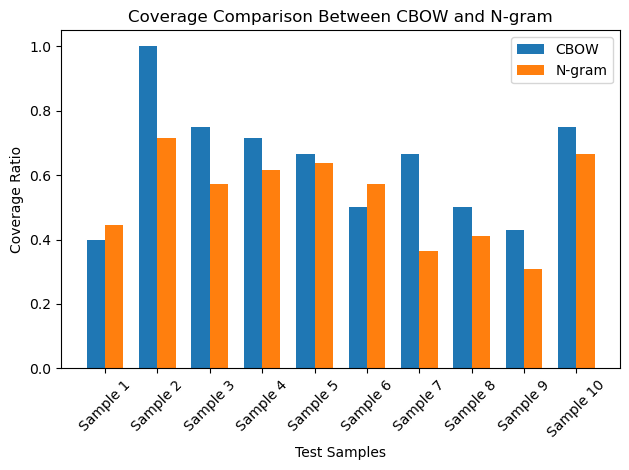

In [ ]:
x = np.arange(len(test_texts))
width = 0.35 

fig, ax = plt.subplots()
cbow_bars = ax.bar(x - width/2, cbow_coverage, width, label='CBOW')
ngram_bars = ax.bar(x + width/2, ngram_coverage, width, label='N-gram')


ax.set_xlabel('Test Samples')
ax.set_ylabel('Coverage Ratio')
ax.set_title('Coverage Comparison Between CBOW and N-gram')
ax.set_xticks(x)
ax.set_xticklabels([f"Sample {i+1}" for i in range(len(test_texts))], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [63]:
for i, text in enumerate(test_texts):
    print(f"Text: {text}")
    print(f"True Label: {test_labels[i]}")
    print(f"CBOW Coverage: {cbow_coverage[i]:.2f}")
    print(f"N-gram Coverage: {ngram_coverage[i]:.2f}")
    print("-" * 50)

Text: Push harder into turn 5.
True Label: 차량 조작 지시
CBOW Coverage: 0.40
N-gram Coverage: 0.44
--------------------------------------------------
Text: The tyres are overheating.
True Label: 차량 상태 피드백
CBOW Coverage: 1.00
N-gram Coverage: 0.71
--------------------------------------------------
Text: Switch to medium tyres.
True Label: 타이어 관련
CBOW Coverage: 0.75
N-gram Coverage: 0.57
--------------------------------------------------
Text: Box this lap for a tyre change.
True Label: 전략 및 계획
CBOW Coverage: 0.71
N-gram Coverage: 0.62
--------------------------------------------------
Text: The car ahead is slowing down.
True Label: 트랙/상대 정보
CBOW Coverage: 0.67
N-gram Coverage: 0.64
--------------------------------------------------
Text: What a fantastic race!
True Label: 감성/개인 표현
CBOW Coverage: 0.50
N-gram Coverage: 0.57
--------------------------------------------------
Text: The engine temperature is too high.
True Label: 시스템/하드웨어 문제
CBOW Coverage: 0.67
N-gram Coverage: 0.36
------------

In [64]:
X_test_cbow = vectorize_cbow(test_texts, word2idx_cbow)
y_test_cbow = np.array([label2idx_cbow[label] for label in test_labels])

X_test_ngram = vectorize_ngram(test_texts, vocab_ngram, ngram_range)
y_test_ngram = np.array([label2idx_ngram[label] for label in test_labels])

In [65]:
acc_cbow, preds_cbow = evaluate_model(X_test_cbow, y_test_cbow, np.dot(W_emb_cbow, W_out_cbow) + b_out_cbow, b_out_cbow)
print(f"CBOW acc: {acc_cbow:.4f}")

acc_ngram, preds_ngram = evaluate_model(X_test_ngram, y_test_ngram, W_ngram, b_ngram)
print(f"N-gram acc: {acc_ngram:.4f}")

CBOW acc: 0.4000
N-gram acc: 0.4000


In [66]:
# 打印预测结果对比
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    pred_cbow = idx2label_cbow[preds_cbow[i]]
    pred_ngram = idx2label_ngram[preds_ngram[i]]
    print(f"Text: {text}")
    print(f"True Label: {true_label}")
    print(f"CBOW Prediction: {pred_cbow}")
    print(f"N-gram Prediction: {pred_ngram}")
    print("-" * 50)

Text: Push harder into turn 5.
True Label: 차량 조작 지시
CBOW Prediction: 차량 조작 지시
N-gram Prediction: 차량 조작 지시
--------------------------------------------------
Text: The tyres are overheating.
True Label: 차량 상태 피드백
CBOW Prediction: 타이어 관련
N-gram Prediction: 타이어 관련
--------------------------------------------------
Text: Switch to medium tyres.
True Label: 타이어 관련
CBOW Prediction: 타이어 관련
N-gram Prediction: 타이어 관련
--------------------------------------------------
Text: Box this lap for a tyre change.
True Label: 전략 및 계획
CBOW Prediction: 차량 조작 지시
N-gram Prediction: 전략 및 계획
--------------------------------------------------
Text: The car ahead is slowing down.
True Label: 트랙/상대 정보
CBOW Prediction: 트랙/상대 정보
N-gram Prediction: 트랙/상대 정보
--------------------------------------------------
Text: What a fantastic race!
True Label: 감성/개인 표현
CBOW Prediction: 차량 조작 지시
N-gram Prediction: 차량 상태 피드백
--------------------------------------------------
Text: The engine temperature is too high.
True Label: 시스

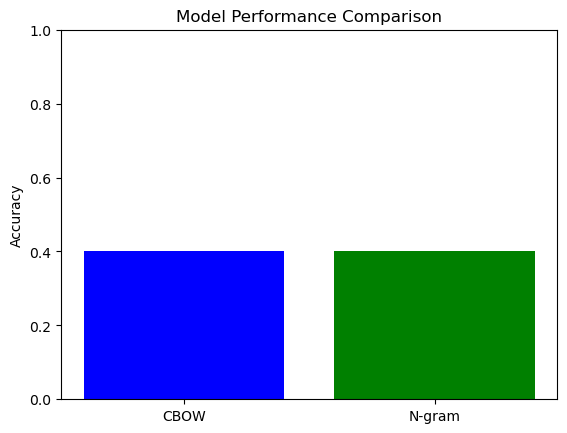

In [67]:
models = ["CBOW", "N-gram"]
accuracies = [acc_cbow, acc_ngram]

plt.bar(models, accuracies, color=["blue", "green"])
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()